In [12]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv('nyc_bb_bicyclist_counts.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])


In [15]:
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day

In [17]:
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=169
Testing data set length=45


In [18]:
expr = """BB_COUNT ~ DAY  + DAY_OF_WEEK + MONTH + HIGH_T + LOW_T + PRECIP"""


In [25]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [47]:
X_train

,Intercept,DAY,DAY_OF_WEEK,MONTH,HIGH_T,LOW_T,PRECIP
Date,,,,,,,
2017-04-01,1.0,1.0,5.0,4.0,46.0,37.0,0.00
2017-04-04,1.0,4.0,1.0,4.0,51.1,46.0,1.18
2017-04-05,1.0,5.0,2.0,4.0,63.0,46.0,0.00
2017-04-06,1.0,6.0,3.0,4.0,48.9,41.0,0.73
2017-04-07,1.0,7.0,4.0,4.0,48.0,43.0,0.01
...,...,...,...,...,...,...,...
2017-10-27,1.0,27.0,4.0,10.0,62.1,48.0,0.00
2017-10-28,1.0,28.0,5.0,10.0,68.0,55.9,0.00
2017-10-29,1.0,29.0,6.0,10.0,64.9,61.0,3.03


In [26]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [27]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  169
Model:                            GLM   Df Residuals:                      162
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13187.
Date:                Tue, 29 Dec 2020   Deviance:                       24743.
Time:                        18:11:43   Pearson chi2:                 2.44e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.0654      0.013    559.274      

In [28]:
df_train['BB_LAMBDA'] = poisson_training_results.mu

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['BB_COUNT'] - x['BB_LAMBDA'])**2 - x['BB_COUNT']) / x['BB_LAMBDA'], axis=1)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""

In [33]:
aux_olsr_results = smf.ols(ols_expr, df_train).fit()

In [34]:
print(aux_olsr_results.tvalues)

BB_LAMBDA    5.721886
dtype: float64


In [35]:
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

In [36]:
print(nb2_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  169
Model:                            GLM   Df Residuals:                      162
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1359.7
Date:                Tue, 29 Dec 2020   Deviance:                       296.67
Time:                        18:16:38   Pearson chi2:                     268.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.8555      0.127     54.127      

In [37]:
nb2_predictions = nb2_training_results.get_prediction(X_test)

In [39]:
predictions_summary_frame = nb2_predictions.summary_frame()
print(predictions_summary_frame.head())

                   mean     mean_se  mean_ci_lower  mean_ci_upper
Date                                                             
2017-04-02  2725.694168  169.751577    2412.491250    3079.558816
2017-04-03  2532.417536  121.523252    2305.094101    2782.159119
2017-04-08  2328.126342  118.962522    2106.259500    2573.363950
2017-04-12  2940.625642  103.453159    2744.693828    3150.544182
2017-04-14  2606.392682   98.458367    2420.388576    2806.690992


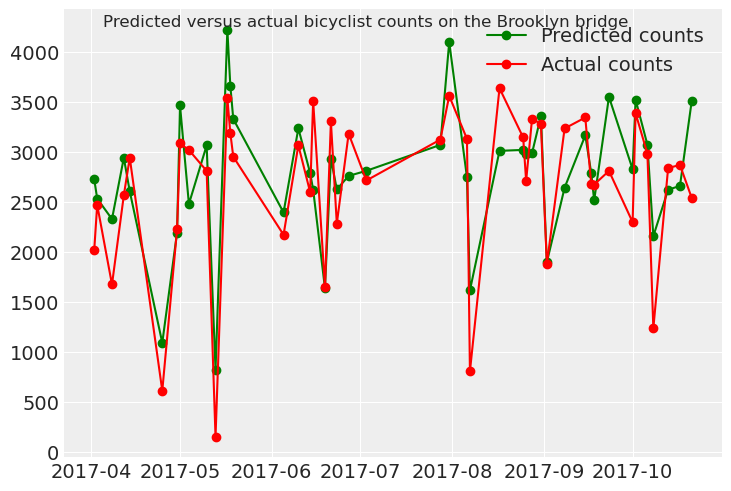

In [44]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['BB_COUNT']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()